# Neural Network for CLA Project

### Import statements

In [7]:
from sklearn import preprocessing
from sklearn import model_selection
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as utils
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import errno
import os
import sys
import Constants
import copy

### Hyperparameters

In [8]:
# data processing
sample_bias = 0     # adjust the difference in the number of the two types of samples (no algae vs algae)
test_size = 0.2
batch_size = 100    # batch size for the DataLoaders. previously was 100

# NN model
num_features = 17
input_size = num_features     # size of input layer
multiplier = 100         # multiplied by num_features to determine the size of each hidden layer. previously was 100
hidden_size = multiplier * input_size
output_size = 1
learning_rate = 0.01         # learning rate of optimizer. previously was 0.01
num_epochs = 100                # number of epochs

### Read in data

In [9]:
np.set_printoptions(threshold=np.inf)  # prints a full matrix rather than an abbreviated matrix

# define data and destination paths
dest_path = "/Users/Alliot/Documents/CLA-Project/Data/all-data-no-na/neural-network/"
data_path = "/Users/Alliot/Documents/CLA-Project/Data/data-sets/"
data_set = "data_2017_summer"

# if dest_path does not exist, create it
if not os.path.exists(dest_path):
    try:
        os.makedirs(dest_path)
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise

# load data sets
X = np.load(data_path + data_set + ".npy")
y = np.load(data_path + data_set + "_labels.npy")

# manipulate data set. labels are converted to -1, +1 for binary classification; samples are removed uniformly 
# from the data set so that the disproportionately large number of negative samples (no algae) does 
# not bias the model.

num_alg = 0  # count the number of algae instances
num_no_alg = 0  # count the number of no algae instances

# Convert labels to binary: -1 for no algae and 1 for algae
for i in range(0, len(y)):
    if y[i] == 0:
        num_no_alg += 1
    if y[i] == 1 or y[i] == 2:
        y[i] = 1
        num_alg += 1

# oversample the data set by randomly adding occurences of algae until the difference between the number of algae
# samples and no algae samples equals sample_bias (defined below)
idx = 0
sample_bias = 0
length_y = len(y)
while num_alg != (num_no_alg + sample_bias):
    # circle through the data sets until the difference of num_no_alg and num_alg equals
    # the value specified by sample_bias
    if idx == (length_y - 1):
        idx = 0

    if y[idx] == 1:
        if np.random.rand() >= 0.5:  # add this sample with some probability
            y = np.append(y, y[idx])
            X = np.append(X, np.reshape(X[idx, :], newshape=(1, num_features)), axis=0)
            num_alg += 1
        else:
            idx += 1
    else:
        idx += 1

### Process and split data set

In [10]:
# standardize data: remove the mean and variance in each sample
num_splits = 2   # do not change
sss = model_selection.StratifiedShuffleSplit(n_splits=num_splits, test_size=test_size)

idx, _ = sss.split(X, y);
train_idx = idx[0]
test_idx = idx[1]
X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

X_train = preprocessing.scale(X_train, axis=1, with_mean=True, with_std=True)
X_test = preprocessing.scale(X_test, axis=1, with_mean=True, with_std=True)

# convert numpy arrays to pytorch tensors
train_set_size = X_train.shape
test_set_size = X_test.shape
X_train, X_test = torch.from_numpy(X_train), torch.from_numpy(X_test)
y_train, y_test = torch.from_numpy(y_train), torch.from_numpy(y_test)

# convert pytorch tensors to pytorch TensorDataset
train_set = utils.TensorDataset(X_train, y_train)
test_set = utils.TensorDataset(X_test, y_test)

# create DataLoaders
train_loader = utils.DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = utils.DataLoader(test_set, batch_size=test_set_size[0], shuffle=True)

### Define neural network model

In [13]:
class CLANet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CLANet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.relu4 = nn.ReLU()
        self.fc5 = nn.Linear(hidden_size, hidden_size)
        self.relu5 = nn.ReLU()
        self.fc6 = nn.Linear(hidden_size, output_size)     # previously, this was output_size
#         self.relu6 = nn.ReLU()                             # previously, this was the line which was commented out
#         self.fc7 = nn.Linear(hidden_size, hidden_size)
#         self.relu7 = nn.ReLU()
#         self.fc8 = nn.Linear(hidden_size, hidden_size)
#         self.relu8 = nn.ReLU()
#         self.fc9 = nn.Linear(hidden_size, output_size)
#         self.relu9 = nn.ReLU()
#         self.fc10 = nn.Linear(hidden_size, hidden_size)
#         self.relu10 = nn.ReLU()
#         self.fc11 = nn.Linear(hidden_size, hidden_size)
#         self.relu11 = nn.ReLU()
#         self.fc12 = nn.Linear(hidden_size, output_size)
        self.sig1 = nn.Sigmoid()
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        out = self.relu3(out)
        out = self.fc4(out)
        out = self.relu4(out)
        out = self.fc5(out)
        out = self.relu5(out)
        out = self.fc6(out)
#         out = self.relu6(out)
#         out = self.fc7(out)
#         out = self.relu7(out)
#         out = self.fc8(out)
#         out = self.relu8(out)
#         out = self.fc9(out)
#         out = self.relu9(out)
#         out = self.fc10(out)
#         out = self.relu10(out)
#         out = self.fc11(out)
#         out = self.relu11(out)
#         out = self.fc12(out)
        out = self.sig1(out)
        return out

### Instantiate the neural network

In [14]:
model = CLANet(input_size, hidden_size, output_size)
criterion = nn.BCELoss()

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, nesterov=True, momentum=1, dampening=0)
model.double();     # cast model parameters to double

### Train the neural network

In [31]:
model.train()     # training mode
training_loss = []
avg_error = 0
avg_error_vec = []
best_avg_error = 1

for epoch in range(num_epochs):
    print("Epoch: %d/%d" % (epoch+1, num_epochs))

    for i, (samples, labels) in enumerate(train_loader):
        samples = Variable(samples)
        labels = Variable(labels)
        output = model(samples)                # forward pass
        output = torch.flatten(output)         # resize predicted labels
        labels = labels.type(torch.DoubleTensor)
        
        loss = criterion(output, labels)  # calculate loss
        optimizer.zero_grad()     # clear gradient
        loss.backward()           # calculate gradients
        optimizer.step()          # update weights
        
        # calculate and print error
        out = output

        for j in range(0, out.size()[0]):
            if out[j] < 0.5:
                out[j] = 0
            else:
                out[j] = 1
        error = 1 - torch.sum(output == labels).item() / labels.size()[0]
        avg_error += error
        training_loss.append(loss.data.numpy())
        print("  Iteration: %d/%d, Loss: %g, Error: %0.4f" % 
              (i+1, np.ceil(X_train.size()[0] / batch_size).astype(int), loss.item(), error))
    
    avg_error = avg_error / np.ceil(X_train.size()[0] / batch_size)
    avg_error_vec.append(avg_error)
    print("Average Error for this Epoch: %0.4f" % avg_error)

    if avg_error < best_avg_error:
        print("found a better model!")
        best_avg_error = avg_error
        best_model = copy.deepcopy(model)
    
    avg_error = 0

Epoch: 1/100
  Iteration: 1/17, Loss: 0.278947, Error: 0.1200
  Iteration: 2/17, Loss: 0.289601, Error: 0.1200
  Iteration: 3/17, Loss: 0.339029, Error: 0.1500
  Iteration: 4/17, Loss: 0.260906, Error: 0.0900
  Iteration: 5/17, Loss: 0.338971, Error: 0.1500
  Iteration: 6/17, Loss: 0.251867, Error: 0.1100
  Iteration: 7/17, Loss: 0.243824, Error: 0.0700
  Iteration: 8/17, Loss: 0.231952, Error: 0.0800
  Iteration: 9/17, Loss: 0.246632, Error: 0.0900
  Iteration: 10/17, Loss: 0.308442, Error: 0.1100
  Iteration: 11/17, Loss: 0.29805, Error: 0.1400
  Iteration: 12/17, Loss: 0.327589, Error: 0.1400
  Iteration: 13/17, Loss: 0.276353, Error: 0.1300
  Iteration: 14/17, Loss: 0.354885, Error: 0.1600
  Iteration: 15/17, Loss: 0.31643, Error: 0.1400
  Iteration: 16/17, Loss: 0.347219, Error: 0.1600
  Iteration: 17/17, Loss: 0.241122, Error: 0.0806
Average Error for this Epoch: 0.1200
found a better model!
Epoch: 2/100
  Iteration: 1/17, Loss: 0.326697, Error: 0.1800
  Iteration: 2/17, Loss: 0.

  Iteration: 4/17, Loss: 0.30889, Error: 0.1400
  Iteration: 5/17, Loss: 0.256507, Error: 0.1000
  Iteration: 6/17, Loss: 0.346851, Error: 0.1600
  Iteration: 7/17, Loss: 0.298801, Error: 0.1400
  Iteration: 8/17, Loss: 0.239477, Error: 0.1000
  Iteration: 9/17, Loss: 0.276961, Error: 0.1100
  Iteration: 10/17, Loss: 0.269872, Error: 0.1200
  Iteration: 11/17, Loss: 0.301773, Error: 0.1100
  Iteration: 12/17, Loss: 0.33429, Error: 0.1600
  Iteration: 13/17, Loss: 0.244392, Error: 0.0600
  Iteration: 14/17, Loss: 0.304607, Error: 0.1500
  Iteration: 15/17, Loss: 0.342635, Error: 0.1500
  Iteration: 16/17, Loss: 0.267899, Error: 0.0900
  Iteration: 17/17, Loss: 0.2219, Error: 0.0484
Average Error for this Epoch: 0.1193
found a better model!
Epoch: 11/100
  Iteration: 1/17, Loss: 0.253622, Error: 0.0900
  Iteration: 2/17, Loss: 0.277052, Error: 0.1200
  Iteration: 3/17, Loss: 0.250795, Error: 0.1000
  Iteration: 4/17, Loss: 0.354108, Error: 0.1900
  Iteration: 5/17, Loss: 0.290071, Error:

  Iteration: 7/17, Loss: 0.263632, Error: 0.0800
  Iteration: 8/17, Loss: 0.328579, Error: 0.1200
  Iteration: 9/17, Loss: 0.240669, Error: 0.1200
  Iteration: 10/17, Loss: 0.255488, Error: 0.0900
  Iteration: 11/17, Loss: 0.314149, Error: 0.1200
  Iteration: 12/17, Loss: 0.274575, Error: 0.1200
  Iteration: 13/17, Loss: 0.29711, Error: 0.1200
  Iteration: 14/17, Loss: 0.324791, Error: 0.1300
  Iteration: 15/17, Loss: 0.225882, Error: 0.0900
  Iteration: 16/17, Loss: 0.299813, Error: 0.1300
  Iteration: 17/17, Loss: 0.393081, Error: 0.2581
Average Error for this Epoch: 0.1240
Epoch: 20/100
  Iteration: 1/17, Loss: 0.280345, Error: 0.0900
  Iteration: 2/17, Loss: 0.339829, Error: 0.1400
  Iteration: 3/17, Loss: 0.316578, Error: 0.1400
  Iteration: 4/17, Loss: 0.327592, Error: 0.1500
  Iteration: 5/17, Loss: 0.361125, Error: 0.1800
  Iteration: 6/17, Loss: 0.325407, Error: 0.1300
  Iteration: 7/17, Loss: 0.306287, Error: 0.1400
  Iteration: 8/17, Loss: 0.317832, Error: 0.1200
  Iteration

  Iteration: 11/17, Loss: 0.313357, Error: 0.1000
  Iteration: 12/17, Loss: 0.330755, Error: 0.1800
  Iteration: 13/17, Loss: 0.346363, Error: 0.1500
  Iteration: 14/17, Loss: 0.361622, Error: 0.1900
  Iteration: 15/17, Loss: 0.365112, Error: 0.1900
  Iteration: 16/17, Loss: 0.220415, Error: 0.0800
  Iteration: 17/17, Loss: 0.273384, Error: 0.0968
Average Error for this Epoch: 0.1204
Epoch: 29/100
  Iteration: 1/17, Loss: 0.294525, Error: 0.1000
  Iteration: 2/17, Loss: 0.307706, Error: 0.1100
  Iteration: 3/17, Loss: 0.242501, Error: 0.0600
  Iteration: 4/17, Loss: 0.277538, Error: 0.0900
  Iteration: 5/17, Loss: 0.249646, Error: 0.1000
  Iteration: 6/17, Loss: 0.261917, Error: 0.1300
  Iteration: 7/17, Loss: 0.279408, Error: 0.1100
  Iteration: 8/17, Loss: 0.367791, Error: 0.1800
  Iteration: 9/17, Loss: 0.293648, Error: 0.1300
  Iteration: 10/17, Loss: 0.381858, Error: 0.1800
  Iteration: 11/17, Loss: 0.268751, Error: 0.1200
  Iteration: 12/17, Loss: 0.240985, Error: 0.0700
  Iterat

  Iteration: 15/17, Loss: 0.219491, Error: 0.0700
  Iteration: 16/17, Loss: 0.26684, Error: 0.1000
  Iteration: 17/17, Loss: 0.255181, Error: 0.0968
Average Error for this Epoch: 0.1204
Epoch: 38/100
  Iteration: 1/17, Loss: 0.327245, Error: 0.1600
  Iteration: 2/17, Loss: 0.356565, Error: 0.1200
  Iteration: 3/17, Loss: 0.325984, Error: 0.1600
  Iteration: 4/17, Loss: 0.294388, Error: 0.1400
  Iteration: 5/17, Loss: 0.28488, Error: 0.1300
  Iteration: 6/17, Loss: 0.279385, Error: 0.1100
  Iteration: 7/17, Loss: 0.256824, Error: 0.0900
  Iteration: 8/17, Loss: 0.244209, Error: 0.1200
  Iteration: 9/17, Loss: 0.292382, Error: 0.1200
  Iteration: 10/17, Loss: 0.241603, Error: 0.0700
  Iteration: 11/17, Loss: 0.312943, Error: 0.1200
  Iteration: 12/17, Loss: 0.306605, Error: 0.1400
  Iteration: 13/17, Loss: 0.293016, Error: 0.1200
  Iteration: 14/17, Loss: 0.280052, Error: 0.1100
  Iteration: 15/17, Loss: 0.272214, Error: 0.1000
  Iteration: 16/17, Loss: 0.262591, Error: 0.1200
  Iteratio

  Iteration: 1/17, Loss: 0.298056, Error: 0.1200
  Iteration: 2/17, Loss: 0.279728, Error: 0.1600
  Iteration: 3/17, Loss: 0.300577, Error: 0.1100
  Iteration: 4/17, Loss: 0.245491, Error: 0.0900
  Iteration: 5/17, Loss: 0.284263, Error: 0.0700
  Iteration: 6/17, Loss: 0.256641, Error: 0.1100
  Iteration: 7/17, Loss: 0.310146, Error: 0.1100
  Iteration: 8/17, Loss: 0.304501, Error: 0.1200
  Iteration: 9/17, Loss: 0.29576, Error: 0.1100
  Iteration: 10/17, Loss: 0.321234, Error: 0.1700
  Iteration: 11/17, Loss: 0.244853, Error: 0.0800
  Iteration: 12/17, Loss: 0.261545, Error: 0.1100
  Iteration: 13/17, Loss: 0.352878, Error: 0.1500
  Iteration: 14/17, Loss: 0.309539, Error: 0.1700
  Iteration: 15/17, Loss: 0.317329, Error: 0.1500
  Iteration: 16/17, Loss: 0.311911, Error: 0.1200
  Iteration: 17/17, Loss: 0.265305, Error: 0.0968
Average Error for this Epoch: 0.1204
Epoch: 48/100
  Iteration: 1/17, Loss: 0.310284, Error: 0.1300
  Iteration: 2/17, Loss: 0.29229, Error: 0.1200
  Iteration:

  Iteration: 5/17, Loss: 0.22073, Error: 0.0800
  Iteration: 6/17, Loss: 0.307215, Error: 0.1700
  Iteration: 7/17, Loss: 0.323516, Error: 0.1500
  Iteration: 8/17, Loss: 0.336347, Error: 0.1200
  Iteration: 9/17, Loss: 0.36661, Error: 0.1700
  Iteration: 10/17, Loss: 0.272042, Error: 0.1100
  Iteration: 11/17, Loss: 0.295595, Error: 0.1300
  Iteration: 12/17, Loss: 0.313499, Error: 0.1300
  Iteration: 13/17, Loss: 0.247172, Error: 0.0800
  Iteration: 14/17, Loss: 0.275382, Error: 0.1000
  Iteration: 15/17, Loss: 0.272253, Error: 0.1200
  Iteration: 16/17, Loss: 0.357386, Error: 0.1700
  Iteration: 17/17, Loss: 0.373035, Error: 0.1613
Average Error for this Epoch: 0.1218
Epoch: 57/100
  Iteration: 1/17, Loss: 0.224067, Error: 0.0600
  Iteration: 2/17, Loss: 0.281181, Error: 0.1200
  Iteration: 3/17, Loss: 0.296802, Error: 0.1200
  Iteration: 4/17, Loss: 0.27698, Error: 0.0900
  Iteration: 5/17, Loss: 0.403071, Error: 0.2300
  Iteration: 6/17, Loss: 0.326749, Error: 0.1600
  Iteration: 

  Iteration: 9/17, Loss: 0.317291, Error: 0.1100
  Iteration: 10/17, Loss: 0.288985, Error: 0.1300
  Iteration: 11/17, Loss: 0.292229, Error: 0.1200
  Iteration: 12/17, Loss: 0.288663, Error: 0.1300
  Iteration: 13/17, Loss: 0.291834, Error: 0.1500
  Iteration: 14/17, Loss: 0.386378, Error: 0.1400
  Iteration: 15/17, Loss: 0.291056, Error: 0.1300
  Iteration: 16/17, Loss: 0.300401, Error: 0.1300
  Iteration: 17/17, Loss: 0.21953, Error: 0.0484
Average Error for this Epoch: 0.1193
Epoch: 66/100
  Iteration: 1/17, Loss: 0.340509, Error: 0.1200
  Iteration: 2/17, Loss: 0.273378, Error: 0.0800
  Iteration: 3/17, Loss: 0.333734, Error: 0.1600
  Iteration: 4/17, Loss: 0.289417, Error: 0.1300
  Iteration: 5/17, Loss: 0.307835, Error: 0.1500
  Iteration: 6/17, Loss: 0.252512, Error: 0.1100
  Iteration: 7/17, Loss: 0.297395, Error: 0.1200
  Iteration: 8/17, Loss: 0.232741, Error: 0.0800
  Iteration: 9/17, Loss: 0.274812, Error: 0.1400
  Iteration: 10/17, Loss: 0.228004, Error: 0.0800
  Iteratio

  Iteration: 13/17, Loss: 0.330707, Error: 0.1500
  Iteration: 14/17, Loss: 0.308923, Error: 0.1300
  Iteration: 15/17, Loss: 0.319999, Error: 0.1400
  Iteration: 16/17, Loss: 0.305116, Error: 0.1300
  Iteration: 17/17, Loss: 0.289132, Error: 0.1129
Average Error for this Epoch: 0.1208
Epoch: 75/100
  Iteration: 1/17, Loss: 0.295663, Error: 0.1000
  Iteration: 2/17, Loss: 0.240705, Error: 0.0600
  Iteration: 3/17, Loss: 0.262382, Error: 0.0900
  Iteration: 4/17, Loss: 0.359378, Error: 0.1600
  Iteration: 5/17, Loss: 0.453253, Error: 0.2200
  Iteration: 6/17, Loss: 0.3029, Error: 0.1000
  Iteration: 7/17, Loss: 0.218436, Error: 0.0800
  Iteration: 8/17, Loss: 0.281618, Error: 0.1300
  Iteration: 9/17, Loss: 0.272184, Error: 0.1200
  Iteration: 10/17, Loss: 0.269813, Error: 0.1200
  Iteration: 11/17, Loss: 0.30845, Error: 0.1300
  Iteration: 12/17, Loss: 0.311091, Error: 0.1500
  Iteration: 13/17, Loss: 0.243605, Error: 0.1000
  Iteration: 14/17, Loss: 0.293185, Error: 0.1200
  Iteration

  Iteration: 1/17, Loss: 0.284469, Error: 0.1100
  Iteration: 2/17, Loss: 0.29757, Error: 0.1400
  Iteration: 3/17, Loss: 0.295079, Error: 0.1400
  Iteration: 4/17, Loss: 0.317984, Error: 0.1400
  Iteration: 5/17, Loss: 0.267762, Error: 0.0900
  Iteration: 6/17, Loss: 0.292517, Error: 0.1100
  Iteration: 7/17, Loss: 0.242457, Error: 0.0700
  Iteration: 8/17, Loss: 0.353201, Error: 0.1800
  Iteration: 9/17, Loss: 0.251578, Error: 0.1000
  Iteration: 10/17, Loss: 0.265601, Error: 0.1000
  Iteration: 11/17, Loss: 0.307741, Error: 0.1300
  Iteration: 12/17, Loss: 0.269476, Error: 0.0900
  Iteration: 13/17, Loss: 0.244594, Error: 0.1100
  Iteration: 14/17, Loss: 0.371761, Error: 0.1700
  Iteration: 15/17, Loss: 0.292178, Error: 0.1100
  Iteration: 16/17, Loss: 0.30538, Error: 0.1300
  Iteration: 17/17, Loss: 0.321128, Error: 0.1452
Average Error for this Epoch: 0.1215
Epoch: 85/100
  Iteration: 1/17, Loss: 0.255435, Error: 0.1000
  Iteration: 2/17, Loss: 0.322789, Error: 0.1700
  Iteration:

  Iteration: 5/17, Loss: 0.342226, Error: 0.1400
  Iteration: 6/17, Loss: 0.275654, Error: 0.0900
  Iteration: 7/17, Loss: 0.244683, Error: 0.1200
  Iteration: 8/17, Loss: 0.285396, Error: 0.0900
  Iteration: 9/17, Loss: 0.245063, Error: 0.0900
  Iteration: 10/17, Loss: 0.270265, Error: 0.1000
  Iteration: 11/17, Loss: 0.235005, Error: 0.1000
  Iteration: 12/17, Loss: 0.349519, Error: 0.1700
  Iteration: 13/17, Loss: 0.302305, Error: 0.1400
  Iteration: 14/17, Loss: 0.284679, Error: 0.1400
  Iteration: 15/17, Loss: 0.285298, Error: 0.1200
  Iteration: 16/17, Loss: 0.374432, Error: 0.2000
  Iteration: 17/17, Loss: 0.326266, Error: 0.1613
Average Error for this Epoch: 0.1218
Epoch: 94/100
  Iteration: 1/17, Loss: 0.309721, Error: 0.1800
  Iteration: 2/17, Loss: 0.38519, Error: 0.2000
  Iteration: 3/17, Loss: 0.26694, Error: 0.0700
  Iteration: 4/17, Loss: 0.337358, Error: 0.1500
  Iteration: 5/17, Loss: 0.315655, Error: 0.1600
  Iteration: 6/17, Loss: 0.337765, Error: 0.1300
  Iteration:

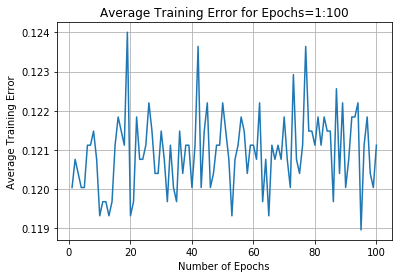

In [32]:
plt.figure()
plt.plot(np.linspace(start=1, stop=100, num=100), avg_error_vec)
plt.xlabel("Number of Epochs")
plt.ylabel("Average Training Error")
plt.title("Average Training Error for Epochs=1:100")
plt.grid(True)
plt.savefig("Neural Net Training Error.jpg")

In [65]:
best_model.train()     # training mode
training_loss = []
avg_error = 0
avg_error_vec = []
best_avg_error = 1

# update learning rate
for p in optimizer.param_groups:
    p["lr"] = 0.005
    p["momentum"] = 0

for epoch in range(num_epochs):
    print("Epoch: %d/%d" % (epoch+1, num_epochs))

    for i, (samples, labels) in enumerate(train_loader):
        samples = Variable(samples)
        labels = Variable(labels)
        output = best_model(samples)                # forward pass
        output = torch.flatten(output)         # resize predicted labels
        labels = labels.type(torch.DoubleTensor)
        
        loss = criterion(output, labels)  # calculate loss
        optimizer.zero_grad()     # clear gradient
        loss.backward()           # calculate gradients
        optimizer.step()          # update weights
        
        # calculate and print error
        out = output

        for j in range(0, out.size()[0]):
            if out[j] < 0.5:
                out[j] = 0
            else:
                out[j] = 1
        error = 1 - torch.sum(output == labels).item() / labels.size()[0]
        avg_error += error
        training_loss.append(loss.data.numpy())
        print("  Iteration: %d/%d, Loss: %g, Error: %0.4f" % 
              (i+1, np.ceil(X_train.size()[0] / batch_size).astype(int), loss.item(), error))
    
    avg_error = avg_error / np.ceil(X_train.size()[0] / batch_size)
    avg_error_vec.append(avg_error)
    print("Average Error for this Epoch: %0.4f" % avg_error)

    if avg_error < best_avg_error:
        print("found a better model!")
        best_avg_error = avg_error
        bester_model = copy.deepcopy(model)
    
    avg_error = 0

Epoch: 1/100
  Iteration: 1/17, Loss: 0.622625, Error: 0.3400
  Iteration: 2/17, Loss: 0.411956, Error: 0.1900
  Iteration: 3/17, Loss: 0.504927, Error: 0.2500
  Iteration: 4/17, Loss: 0.609038, Error: 0.2700
  Iteration: 5/17, Loss: 0.495922, Error: 0.2400
  Iteration: 6/17, Loss: 0.428102, Error: 0.1900
  Iteration: 7/17, Loss: 0.543123, Error: 0.2500
  Iteration: 8/17, Loss: 0.533241, Error: 0.2700
  Iteration: 9/17, Loss: 0.424661, Error: 0.2100
  Iteration: 10/17, Loss: 0.494133, Error: 0.2500
  Iteration: 11/17, Loss: 0.577836, Error: 0.2600
  Iteration: 12/17, Loss: 0.464019, Error: 0.1800
  Iteration: 13/17, Loss: 0.527645, Error: 0.2800
  Iteration: 14/17, Loss: 0.479384, Error: 0.2500
  Iteration: 15/17, Loss: 0.459471, Error: 0.2100
  Iteration: 16/17, Loss: 0.495459, Error: 0.2700
  Iteration: 17/17, Loss: 0.438126, Error: 0.2742
Average Error for this Epoch: 0.2461
found a better model!
Epoch: 2/100
  Iteration: 1/17, Loss: 0.488148, Error: 0.2800
  Iteration: 2/17, Loss: 

  Iteration: 4/17, Loss: 0.528029, Error: 0.2800
  Iteration: 5/17, Loss: 0.42453, Error: 0.2000
  Iteration: 6/17, Loss: 0.553176, Error: 0.2600
  Iteration: 7/17, Loss: 0.4854, Error: 0.2700
  Iteration: 8/17, Loss: 0.50308, Error: 0.2200
  Iteration: 9/17, Loss: 0.516301, Error: 0.2100
  Iteration: 10/17, Loss: 0.601661, Error: 0.3200
  Iteration: 11/17, Loss: 0.484163, Error: 0.2400
  Iteration: 12/17, Loss: 0.524353, Error: 0.2600
  Iteration: 13/17, Loss: 0.545525, Error: 0.3000
  Iteration: 14/17, Loss: 0.458203, Error: 0.2200
  Iteration: 15/17, Loss: 0.494264, Error: 0.2300
  Iteration: 16/17, Loss: 0.475658, Error: 0.2100
  Iteration: 17/17, Loss: 0.39547, Error: 0.1452
Average Error for this Epoch: 0.2432
found a better model!
Epoch: 11/100
  Iteration: 1/17, Loss: 0.576151, Error: 0.2900
  Iteration: 2/17, Loss: 0.498855, Error: 0.2500
  Iteration: 3/17, Loss: 0.454486, Error: 0.2000
  Iteration: 4/17, Loss: 0.562767, Error: 0.2200
  Iteration: 5/17, Loss: 0.489956, Error: 

  Iteration: 8/17, Loss: 0.49234, Error: 0.2700
  Iteration: 9/17, Loss: 0.557936, Error: 0.3300
  Iteration: 10/17, Loss: 0.511948, Error: 0.2700
  Iteration: 11/17, Loss: 0.495477, Error: 0.2500
  Iteration: 12/17, Loss: 0.508989, Error: 0.2300
  Iteration: 13/17, Loss: 0.530157, Error: 0.2200
  Iteration: 14/17, Loss: 0.575233, Error: 0.2600
  Iteration: 15/17, Loss: 0.509041, Error: 0.2500
  Iteration: 16/17, Loss: 0.480794, Error: 0.2200
  Iteration: 17/17, Loss: 0.569989, Error: 0.3226
Average Error for this Epoch: 0.2472
Epoch: 20/100
  Iteration: 1/17, Loss: 0.496491, Error: 0.2400
  Iteration: 2/17, Loss: 0.462284, Error: 0.2500
  Iteration: 3/17, Loss: 0.43273, Error: 0.2300
  Iteration: 4/17, Loss: 0.503928, Error: 0.2100
  Iteration: 5/17, Loss: 0.479755, Error: 0.2300
  Iteration: 6/17, Loss: 0.563279, Error: 0.2600
  Iteration: 7/17, Loss: 0.471959, Error: 0.2500
  Iteration: 8/17, Loss: 0.491287, Error: 0.2600
  Iteration: 9/17, Loss: 0.476646, Error: 0.2500
  Iteration:

  Iteration: 12/17, Loss: 0.488957, Error: 0.2200
  Iteration: 13/17, Loss: 0.523457, Error: 0.2600
  Iteration: 14/17, Loss: 0.52456, Error: 0.2600
  Iteration: 15/17, Loss: 0.482592, Error: 0.2300
  Iteration: 16/17, Loss: 0.437422, Error: 0.2400
  Iteration: 17/17, Loss: 0.464585, Error: 0.2419
Average Error for this Epoch: 0.2454
Epoch: 29/100
  Iteration: 1/17, Loss: 0.46703, Error: 0.2400
  Iteration: 2/17, Loss: 0.468001, Error: 0.2300
  Iteration: 3/17, Loss: 0.466934, Error: 0.2100
  Iteration: 4/17, Loss: 0.5656, Error: 0.2600
  Iteration: 5/17, Loss: 0.600441, Error: 0.3300
  Iteration: 6/17, Loss: 0.475842, Error: 0.2700
  Iteration: 7/17, Loss: 0.437418, Error: 0.2200
  Iteration: 8/17, Loss: 0.507081, Error: 0.2800
  Iteration: 9/17, Loss: 0.505665, Error: 0.2100
  Iteration: 10/17, Loss: 0.479805, Error: 0.1600
  Iteration: 11/17, Loss: 0.494215, Error: 0.2100
  Iteration: 12/17, Loss: 0.615408, Error: 0.3300
  Iteration: 13/17, Loss: 0.578672, Error: 0.3000
  Iteration:

KeyboardInterrupt: 

### Evaluate Model on Testing Set

In [33]:
best_model.eval()

for i, (samples, labels) in enumerate(test_loader):
    samples = Variable(samples)
    labels = Variable(labels)
    predictions = best_model(samples)
    predictions = torch.flatten(predictions)
    labels = labels.type(torch.DoubleTensor)

    for j in range(0, predictions.size()[0]):
        if predictions[j] < 0.5:
            predictions[j] = 0
        else:
            predictions[j] = 1
    
    error = 1 - torch.sum(predictions == labels).item() / labels.size()[0]
    
    print("Testing set Error: %0.4f" % error)
    
model_path = "./torch_model_3_4_19_lr=" + str(learning_rate) + "_dict.pt"

Testing set Error: 0.1707


### Save Model

In [34]:
torch.save(model.state_dict(), model_path)

### Load and Evaluate previous models

In [8]:
model = CLANet(input_size, hidden_size, output_size)
model.load_state_dict(torch.load("torch_model_2_18_19_lr=0.01_dict.pt"))
model.double()     # cast model parameters to double
model.eval()

for i, (samples, labels) in enumerate(test_loader):
    samples = Variable(samples)
    labels = Variable(labels)
    predictions = model(samples)
    predictions = torch.flatten(predictions)
    labels = labels.type(torch.DoubleTensor)

    for j in range(0, predictions.size()[0]):
        if predictions[j] < 0.5:
            predictions[j] = 0
        else:
            predictions[j] = 1
    
    error = 1 - torch.sum(predictions == labels).item() / labels.size()[0]
    
    print("Testing set Error: %0.4f" % error)

/Users/Alliot/anaconda3/lib/python3.6/site-packages/torch/serialization.py:400: UserWarning: Couldn't retrieve source code for container of type CLANet. It won't be checked for correctness upon loading.
  "type " + container_type.__name__ + ". It won't be checked "


RuntimeError: storage has wrong size: expected -8422397943574246465 got 850

In [30]:
for p in optimizer.param_groups:
    p["lr"] = 0.00001